In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [2]:
processed_dataset  = "processed_data"

# Loading npy(s)

In [3]:
from scipy.ndimage import zoom
import os
N = len(next(os.walk("%s/voxelizations" % processed_dataset))[2])


# carico il training set
print("Caricamento training set...")

voxelizations      = []
voxelization_specs = []
centers_of_mass    = []
finger_prints      = []


for i in range(N):
    voxelization       = jnp.array(np.load("%s/voxelizations/voxelization_%d.npy"           % (processed_dataset,i)))
    voxelization_spec  = jnp.array(np.load("%s/voxelization_specs/voxelization_spec_%d.npy" % (processed_dataset,i)))
    center_of_mass     = jnp.array(np.load("%s/centers_of_mass/center_of_mass_%d.npy"       % (processed_dataset,i)))
    finger_print       = jnp.array(np.load("%s/finger_prints/finger_print_%d.npy"           % (processed_dataset,i)))
    
    voxelization_specs.append(voxelization_spec)
    voxelizations.append(zoom(voxelization,(0.5,0.5,0.5)))
    centers_of_mass.append(center_of_mass)
    finger_prints.append(finger_print)
    
    if int( i / (N / 10)) != int( (i + 1)/ (N/10) ):
        print("%d su %d" % (i , N))

Caricamento training set...
10 su 101
20 su 101
30 su 101
40 su 101
50 su 101
60 su 101
70 su 101
80 su 101
90 su 101
100 su 101


In [4]:
shapes      = np.array([ np.array(a.shape) for a in voxelizations ])
magic_shape = shapes.max(axis = 0)
magic_shape

array([37, 33, 40])

## Conversione dei dati caricati in formato array

In [5]:
voxelizations       = [ jnp.array(o) for o in voxelizations      ]
voxelization_specs  = [ jnp.array(o) for o in voxelization_specs ]
centers_of_mass     = [ jnp.array(o) for o in centers_of_mass    ]
finger_prints       = [ jnp.array(o) for o in finger_prints      ]

# Center of mass gaussianization

In [6]:
def center_of_mass_gaussianization(
        com,                      # centro di massa
        voxelization_orig_shape , # dimensione della voxelizzazione prima di essere paddata
        voxelization_specs      , # specifiche geometriche della voxelizzazioen (xmin,xmax,ymin,ymax,zmin,zmax)
        sigma = 5.                # deviazione standard della gaussiana
):
    # ritorna una voxelgrid in cui il centro di massa é rappresentato attraverso una gaussiana 
    # di varianza sigma_sq
    
    grid = np.zeros((voxelization_orig_shape[0],
                     voxelization_orig_shape[1],
                     voxelization_orig_shape[2]))
    
    x_min,x_max,y_min,y_max,z_min,z_max = voxelization_specs

    X   = jnp.linspace(x_min,x_max, voxelization_orig_shape[0])
    Y   = jnp.linspace(y_min,y_max, voxelization_orig_shape[1])
    Z   = jnp.linspace(z_min,z_max, voxelization_orig_shape[2])
    
    # faccio il meshgrid dei linspace
    XYZ = jnp.meshgrid(X,Y,Z, indexing = 'ij')

    
    grid =  jax.vmap(
                        lambda x,y,z: 
                            jnp.exp( - (
                                        (x - com[0])**2 +      
                                        (y - com[1])**2 + 
                                        (z - com[2])**2
                                       ) / (sigma**2)           # divido per la varianza
                                   )
                    )(XYZ[0],
                      XYZ[1],
                      XYZ[2])


    grid = np.array(grid)
    return grid
    

In [7]:
voxelization_specs[0]

DeviceArray([-1.307, 26.864, -9.073, 20.774, 13.342, 41.422], dtype=float32)

### Costruisco il dataset dei centri di massa

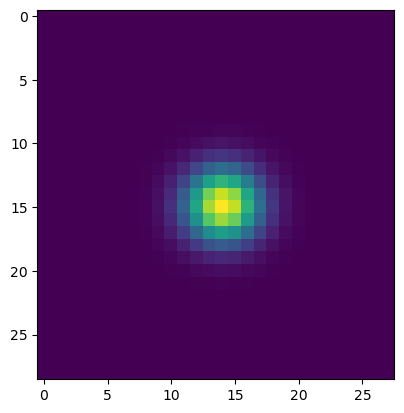

In [8]:
coms = [
    center_of_mass_gaussianization(
    centers_of_mass[i],
    voxelizations[i].shape,
    voxelization_specs[i],
    3.
    )
    
    for i in range(len(voxelizations))
]
plt.imshow(coms[0].mean(axis = 0))

# Padding

In [9]:
def padding(array, requested_shape):
    xx = requested_shape[0]
    yy = requested_shape[1]
    zz = requested_shape[2]
    
    sa = array.shape[0]
    sb = array.shape[1]
    sc = array.shape[2] 
    
    a = (xx - sa) // 2
    aa = xx - a - sa
    b = (yy - sb) // 2
    bb = yy - b - sb
    c = (zz - sc) // 2
    cc = zz - c - sc
    
    return jnp.pad(array, pad_width=((a, aa), (b, bb), (c,cc)), mode='constant')

# GridDecomp

In [10]:
import jax
import jax.numpy as jnp
from jax import lax
from jax.lax import dynamic_slice

def conv3D(grid,W):
    G = grid.copy()
    def relu(x):
        return jnp.maximum(0,x)
    
    # put zeros "around"
    G = jnp.pad(G,int(W.shape[0]/2))
    
    G = jax.vmap(
            lambda i:
            jax.vmap(
                lambda j:
                jax.vmap(
                    lambda k:
                        ( 
                                (dynamic_slice( G,(i - int(W.shape[0] / 2.) , j - int(W.shape[1] / 2.), k - int(W.shape[2] / 2.)) , 
                                      (W.shape[0],W.shape[1],W.shape[2]) ) * W).mean()
                        )
                )( jnp.arange( int(W.shape[2] / 2.) ,G.shape[2] - int(W.shape[2] / 2.)).astype(int) )
            )( jnp.arange( int(W.shape[1] / 2.), G.shape[1] - int(W.shape[1] / 2.)).astype(int) )
        )( jnp.arange( int(W.shape[0] / 2.), G.shape[0] - int(W.shape[0] / 2.)).astype(int) )
        
    return G
conv3D = jax.jit(conv3D)

In [100]:
X = []
Y = []
n   = 10
for i,v in enumerate(voxelizations):
    print(i)
    for j in range(n , v.shape[0] - n):
        for k in range(n, v.shape[1] - n):
            for l in range(n, v.shape[2] - n):
                X.append( v[j - n : j + n, k - n : k + n , l - n : l + n] )
                Y.append( coms[i][j,k,l] )
X = jnp.array(X)
Y = jnp.array(Y)

indici_train = np.random.choice(2,size = len(X), p = [0.2,0.8]) == 1
X_train = X[indici_train]
X_test  = X[~indici_train]
Y_train = Y[indici_train]
Y_test  = Y[~indici_train]
print( (X_train.shape, Y_train.shape), (X_test.shape, Y_test.shape) )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
((29421, 20, 20, 20), (29421,)) ((7189, 20, 20, 20), (7189,))


In [104]:
X_ = X_train.reshape(-1, np.prod(X.shape[1:]))
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter = 200).fit(X_, Y_train > 0.7)

C:\Users\Luca\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [105]:
X_test_ = X_test.reshape(-1, np.prod(X.shape[1:]))
Y_test_pred = clf.predict(X_test_)

<AxesSubplot:>

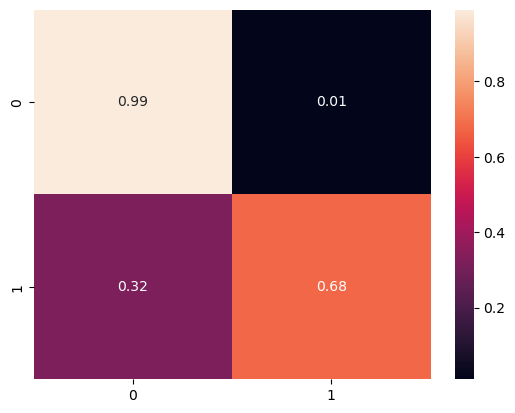

In [164]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(Y_test > 0.7, Y_test_pred, normalize='true')
import seaborn as sns
sns.heatmap(CM, annot = True)

# Reconstruct

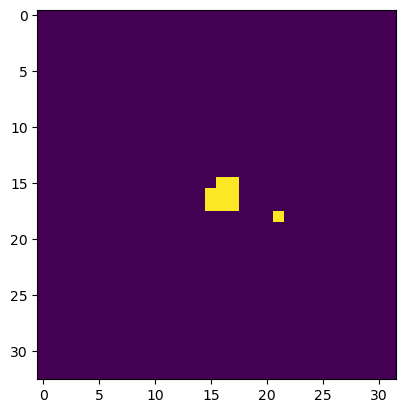

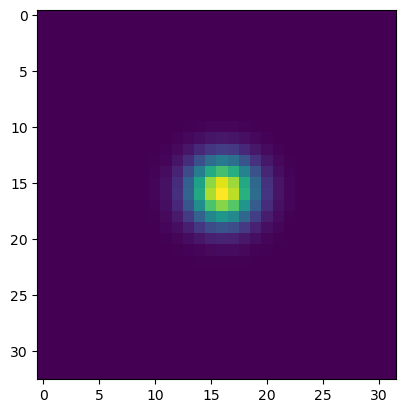

In [165]:
def reconstruct(v):
    n   = 10
    ret = np.zeros((v.shape[0], v.shape[1], v.shape[2]))
    for j in range(n , v.shape[0] - n):
        for k in range(n, v.shape[1] - n):
            for l in range(n, v.shape[2] - n):
                X_curr  = v[j - n : j + n, k - n : k + n , l - n : l + n].flatten()
                ret[j,k,l] = clf.predict(X_curr[None,:])[0]
    return ret

n = 13
plt.imshow( reconstruct(voxelizations[n]).max(axis = 0) )
plt.figure()
plt.imshow( (coms[n]).max(axis = 0) )

### Prova su translazioni

In [109]:
class Translation:
    def __init__(self,vox):
        vox_mean      = (np.array(vox.shape) / 2).astype(int)
        self.r_vector = ((np.random.uniform(size = len(vox.shape)) * 2 - 1.)*3).astype(int)

    def __call__(self, x):
        r_x = self.r_vector[0]
        r_y = self.r_vector[1]
        r_z = self.r_vector[2]

        v_x = x.shape[0]
        v_y = x.shape[1]
        v_z = x.shape[2]


        if r_x > 0:    # traslazione positiva
            x = jnp.concatenate([x, jnp.zeros((r_x,v_y,v_z))], axis = 0)
            x = x[r_x:,:,:]
        else:          # traslazione negativa
            if r_x < 0:
                r_x *= -1
                x = jnp.concatenate([jnp.zeros((r_x,v_y,v_z)), x], axis = 0)
                x = x[:-r_x,:,:]       

        if r_y > 0:
            x = jnp.concatenate([x, jnp.zeros((v_x,r_y,v_z))], axis = 1)
            x = x[:,r_y:,:]
        else:
            if r_y < 0:
                r_y *= -1
                x = jnp.concatenate([jnp.zeros((v_x,r_y,v_z)),x], axis = 1)
                x = x[:,:-r_y,:]    

        if r_z > 0:
            x = jnp.concatenate([x, jnp.zeros((v_x,v_y,r_z))], axis = 2)
            x = x[:,:,r_z:]
        else:
            if r_z < 0:
                r_z *= -1
                x = jnp.concatenate([jnp.zeros((v_x,v_y,r_z)), x], axis = 2)
                x = x[:,:,:-r_z]

        return x

In [110]:
import matplotlib
highlightermap = matplotlib.colors.LinearSegmentedColormap.from_list("",[
                                                          np.array([1.,0.,0.,0.]),
                                                          np.array([1.,0.,0.,1.])]
                                                          )

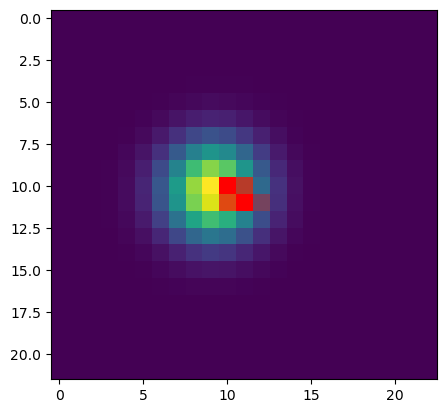

In [206]:

n = 25
T = Translation(voxelizations[n])
plt.imshow( T(coms[n]).mean(axis = 0) )
plt.imshow( reconstruct(T(voxelizations[n])).mean(axis = 0) , cmap = highlightermap)


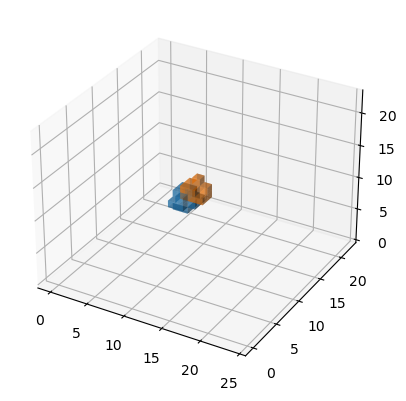

In [210]:
ax = plt.figure().add_subplot(projection = '3d')
ax.voxels(np.array(T(coms[n])) > 0.7, alpha = 0.5) 
ax.voxels(np.array(reconstruct(T(voxelizations[n]))) > 0.7, alpha = 0.5)
plt.show()